# Preprocesamiento de datos

## Objetivos particulares:

1. Entender los datos que representan las columnas.
2. Implementar una política de datos faltantes.
3. Creación de columnas para crear mejor información.
4. Segmentar en regiones geográficas de México.
5. Eliminación de columnas con datos innecesarios.
6. Homogeneizar los datos.

## Librerías

In [265]:
import pandas as pd
import numpy as np
import random
import copy
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

## 1. Cargar el conjunto de datos ENDIREH Sección IX: Atención Obstétrica

In [266]:
ruta_parcial = "../../conjunto_de_datos_endireh_2016_csv/conjunto_de_datos_tb_sec_ix_endireh_2016/conjunto_de_datos/conjunto_de_datos_tb_sec_ix_endireh_2016.csv"

endireh = pd.read_csv(ruta_parcial, na_values=['\r'])

In [267]:
endireh.iloc[random.choices(range(endireh.shape[0]), k=5)]

,ID_VIV,ID_MUJ,UPM,REN_M_ELE,VIV_SEL,PROG,HOGAR,DOMINIO,CVE_ENT,NOM_ENT,...,P9_8_10,P9_8_11,P9_8_12,P9_8_13,P9_8_14,FAC_VIV,FAC_MUJ,ESTRATO,UPM_DIS,EST_DIS
81221,2062694.16,2062694.16.01.02\r,2062694,2,16,14,1,R\r,20,Oaxaca\r,...,NaN,NaN,NaN,NaN,NaN,280,280,1,11302,3660
24869,803910.03,0803910.03.01.02\r,803910,2,3,66,1,U\r,8,Chihuahua\r,...,2.0,2.0,NaN,NaN,NaN,383,383,3,4399,1320
10688,400603.02,0400603.02.01.03\r,400603,3,2,110,1,U\r,4,Campeche\r,...,NaN,NaN,NaN,NaN,NaN,69,139,2,2072,510
38461,1202712.03,1202712.03.01.03\r,1202712,3,3,83,1,U\r,12,Guerrero\r,...,NaN,NaN,NaN,NaN,NaN,237,237,2,7004,2090
108001,2860209.07,2860209.07.01.02\r,2860209,2,7,32,1,R\r,28,Tamaulipas\r,...,NaN,NaN,NaN,NaN,NaN,328,983,1,15989,5320


## 2. Preservar los datos de las embarazadas

Borrar los registros de todas aquellas que repondieron que no estuvieron embarazadas entre Octubre 2011 hasta finales 2016 o que no se tenga resgistro de su respuesta. La manera fácil es solo preservar los registros de las que respondieron que sí estuvieron embaraadas en ese periodo de tiempo.

In [268]:
endireh = endireh[endireh.P9_2 == 1]

In [269]:
endireh.reset_index(drop=True, inplace=True) #reajustar el índice

## 3. Agregar columnas

### 3.1 Datos faltantes a preguntas de servicio médico.

En la pregunta 1 y 5, si todos los registros tienen valor 9 significa que no hay registro de la respuesta a esa pregunta, por ello se grega una columna que refleje esa información y todos los demás valores se hacen 0, así se preserva el _One Hot Encoding_.

#### Pregunta 1

In [270]:
endireh.insert(24, "P9_1_10", 0.0) #agregar columna con ceros

In [271]:
endireh.loc[endireh['P9_1_1']==9, 'P9_1_10'] = 1.0 #asignar los valores de columnas con 9

In [272]:
endireh.loc[endireh['P9_1_1']==9, [F'P9_1_{i}' for i in range(1,10)]] = 0.0 #los valores con 9 se hacen 0

#### Pregunta 5

In [273]:
endireh.insert(41, "P9_5_12", 0.0) #agregar columna con ceros

In [274]:
endireh.loc[endireh['P9_5_1']==9, 'P9_5_12']=1.0 #asignar los valores de columnas con 9

In [275]:
endireh.loc[endireh['P9_5_1']==9, [F'P9_5_{i}' for i in range(1,12)]]=0.0 #los valores con 9 se hacen 0

### 3.2 Crear clasificación

A partir de las respuestas de la pregunta 8, crear columna que va a servir de clasificación para los niveles de violencia obstétrica.

In [276]:
def f(row):
    # va de menor a mayor gravedad
    val = 0 #ninguno
    if row['P9_8_1'] == 1.0 or row['P9_8_2'] == 1.0 or row['P9_8_3'] == 1.0 or row['P9_8_6'] == 1.0: #humillante
        val = 1
    if row['P9_8_7'] == 1.0 or row['P9_8_8'] == 1.0: #salud reproductiva
        val = 2
    if row['P9_8_4'] == 1.0 or row['P9_8_5'] == 1.0 or row['P9_8_10'] == 1.0: #atencion medica
        val = 3
    if row['P9_8_9'] == 1.0 or row['P9_8_14'] == 4.0: #grave
        val = 4
        
    return val

In [277]:
endireh.insert(58, "P9_8", endireh.apply(f, axis=1))

#### 3.2.1 Distribución de clases

Ninguno:	73%
Humillante:	11%
Salud R.:	8%
A. médica:	6%
Graveee:	2%


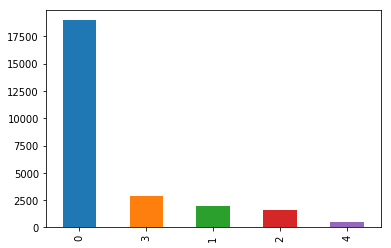

In [278]:
for i,j in zip(['Ninguno', 'Humillante', 'Salud R.', 'A. médica', 'Graveee'], endireh["P9_8"].value_counts()/endireh["P9_8"].value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
endireh["P9_8"].value_counts().plot(kind='bar')

In [279]:
endireh.shape[0]*.27

6983.280000000001

Por lo tanto solo 27% de los registros sufrieron violencia obstétrica durante el parto lo que equivale a 6983 personas. 
# ¿Es esto suficiente?

### 3.2 Crear una segunda clasificación

A partir de las respuestas de la pregunta 8, crear columna diferente a la anterior para comparar métodos que va a servir de clasificación para los niveles de violencia obstétrica.

In [280]:
def f(row):
    # va de menor a mayor gravedad
    val = 0 #ninguno
    
    #abuso y violencia
    if row['P9_8_1'] == 1.0 or row['P9_8_2'] == 1.0 or row['P9_8_3'] == 1.0 or row['P9_8_4'] == 1.0 or row['P9_8_5'] == 1.0 or row['P9_8_6'] == 1.0:
        val = 1
    
    #atencion no autorizada
    if row['P9_8_7'] == 1.0 or row['P9_8_8'] == 1.0 or row['P9_8_9'] == 1.0 or row['P9_8_10'] == 1.0 or row['P9_8_14'] == 4.0:
        val = 2
    
    return val

In [281]:
endireh.insert(58, "P9_9", endireh.apply(f, axis=1))

#### 3.3.1 Distribución de clases

Ninguno:	0.7337612124961336%
Abuso y violencia:	0.138648314259202%
Atencion no autorizada:	0.1275904732446644%


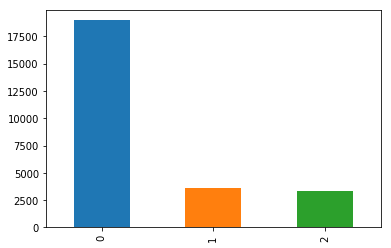

In [282]:
for i,j in zip(['Ninguno', 'Abuso y violencia', 'Atencion no autorizada'], endireh["P9_9"].value_counts()/endireh["P9_9"].value_counts().sum()):
    print(f'{i}:\t{j}%')
endireh["P9_9"].value_counts().plot(kind='bar')

Con la clasificación propuesta en [este artículo](file:///C:/Users/Ang%C3%A9lica/Documents/1%20TICs%202021-2/tutoria/67.Maltratodurantelaatencinobsttrica.pdf) en la pagina 9, da mejor distribución de las variables.

### 3.3 Crear una segunda clasificación

A partir de las respuestas de la pregunta 8, crear columna diferente a la anterior para comparar métodos que va a servir de clasificación para los niveles de violencia obstétrica.

Siguiendo el libro y el del 3.2 marcar si sufrió de ambos tipos de violencia (tercera clasificación)

In [283]:
def f(row):
    # va de menor a mayor gravedad
    val = [0,0] #ninguno
    
    #abuso y violencia
    if row['P9_8_1'] == 1.0 or row['P9_8_2'] == 1.0 or row['P9_8_3'] == 1.0 or row['P9_8_4'] == 1.0 or row['P9_8_5'] == 1.0 or row['P9_8_6'] == 1.0:
        val[0] = 1
    
    #atencion no autorizada
    if row['P9_8_7'] == 1.0 or row['P9_8_8'] == 1.0 or row['P9_8_9'] == 1.0 or row['P9_8_10'] == 1.0 or row['P9_8_14'] == 4.0:
        val[1] = 1
    
    if val[0]==1 and val[1]==1:
        return 3
    elif val[0]==1:
        return 1
    elif val[1]==1:
        return 2
    else: 
        return 0

In [284]:
endireh.insert(58, "P9_11", endireh.apply(f, axis=1))

#### 3.3.1 Distribución de clases

Ninguno:	73%
Abuso y violencia:	14%
Atencion no autorizada:	7%
Ambos:	6%


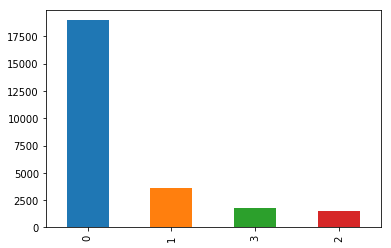

In [286]:
for i,j in zip(['Ninguno', 'Abuso y violencia', 'Atencion no autorizada', 'Ambos'], endireh["P9_11"].value_counts()/endireh["P9_11"].value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
endireh["P9_11"].value_counts().plot(kind='bar')

In [289]:
.15/.73 # necesito el 20% de los no para obtener la muestra representativa

0.2054794520547945

In [292]:
100*.73*.20

14.600000000000001

## 4. Borrar columnas

### 4.1  Las columnas con datos que ya son representados en otras columnas son:

<center>[NOM_ENT, NOM_MUN]</center>

Eliminar las columnas de nombre de municipio y nombre del estado que ya está representados con números en otras columnas.


In [173]:
endireh.drop(labels=['NOM_ENT', 'NOM_MUN'], axis=1, inplace=True)

### 4.2 Las columnas con datos innecesarios:

<center>[COD_RES_MU, COD_RES, P9_2]</center>

Eliminar las columnas cuyos registros solo tomen un valor. En este caso las columnas que representan el estatus de haber sido completadas y de estar embarazada (cuya variabilidad de acorto en el inciso 2).

In [174]:
endireh.drop(labels=['COD_RES_MU', 'COD_RES', 'P9_2'], axis=1, inplace=True)

### 4.3 Las columnas de violencia obtétrica durante el parto:

<center>[P9_8_1, ..., P9_8_10, P9_8_12]</center>

Eliminar las columnas cuyos registros se utilisen para la creación de la clasificación. Preservando los datos de si el último hijo nació por cesárea, y quién dió la autorización para la cesárea.

In [175]:
columnas = [f'P9_8_{i}' for i in range(1,11)]
columnas.append('P9_8_12')

In [176]:
endireh.drop(labels=columnas, axis=1, inplace=True)

## 5. Limpiar columnas

Las columnas con datos por limpiar (que sus datos terminan en __\r__) :

Usamos expresiones regulares para quedarnos con la parte de la expresión que no tiene el termino \r

In [177]:
endireh_r = copy.copy(endireh)

In [178]:
endireh_r = endireh.replace(regex=r'(\w+)(\W)*\r', value=r'\1')

In [179]:
endireh_r.head(10)

,ID_VIV,ID_MUJ,UPM,REN_M_ELE,VIV_SEL,PROG,HOGAR,DOMINIO,CVE_ENT,CVE_MUN,...,P9_7,P9_8_11,P9_8_13,P9_8_14,P9_8,FAC_VIV,FAC_MUJ,ESTRATO,UPM_DIS,EST_DIS
0,100097.01,0100097.01.01.02,100097,2,1,18,1,U,1,1,...,5.0,1.0,1.0,NaN,0,82,82,2,28,10
1,100101.04,0100101.04.01.03,100101,3,4,51,1,U,1,1,...,5.0,1.0,2.0,4.0,4,94,189,3,29,20
2,100105.03,0100105.03.01.02,100105,2,3,171,1,U,1,1,...,2.0,2.0,NaN,NaN,3,85,85,3,31,20
3,100109.01,0100109.01.01.04,100109,4,1,21,1,U,1,1,...,5.0,1.0,1.0,NaN,0,92,185,3,32,20
4,100109.03,0100109.03.01.02,100109,2,3,33,1,U,1,1,...,6.0,1.0,1.0,NaN,0,92,92,3,32,20
5,100003.03,0100003.03.01.02,100003,2,3,61,1,U,1,1,...,6.0,1.0,1.0,NaN,0,115,115,4,2,30
6,100018.04,0100018.04.01.02,100018,2,4,115,1,U,1,1,...,5.0,2.0,NaN,NaN,0,92,92,3,7,20
7,100025.01,0100025.01.01.07,100025,7,1,9,1,U,1,1,...,5.0,2.0,NaN,NaN,0,92,92,3,9,20
8,100025.02,0100025.02.01.02,100025,2,2,28,1,U,1,1,...,6.0,1.0,1.0,NaN,0,92,92,3,9,20
9,100025.05,0100025.05.01.03,100025,3,5,68,1,U,1,1,...,2.0,1.0,1.0,NaN,0,92,184,3,9,20


## 6. Guardar le dataset

In [180]:
#guardo los avances
endireh_r.to_csv("datasets/sec_ix.csv")